In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
import numba
from numba import jit

from config import DefaultConfig
from dataset import CustomDataset
from augmentations import get_train_transforms, get_valid_transforms
import utils

import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = '7'
device = torch.device(DefaultConfig.device) if torch.cuda.is_available() else torch.device('cpu')

utils.seed_everything(DefaultConfig.seed)

df = pd.read_csv('./data/updated_train_labels.csv')
df['jpg_path'] = df['id'].apply(utils.get_train_file_path)
train = df.copy()
display(train.head())

df_folds = train.copy()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=DefaultConfig.seed)
for n, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds.integer_label)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = int(n)
df_folds['fold'] = df_folds['fold'].astype(int)
print(df_folds.groupby(['fold', df_folds.integer_label]).size())

,id,dcm_path,xmin,ymin,xmax,ymax,human_label,negative,typical,indeterminate,...,ImageInstanceUID,img_shape,width,height,frac_xmin,frac_xmax,frac_ymin,frac_ymax,integer_label,jpg_path
0,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,2245.91208,591.20528,3340.57370,2352.75472,typical,0,1,0,...,000a312787f2,"(3488, 4256)",4256,3488,0.527705,0.784909,0.169497,0.674528,3,./data512/train/000a312787f2.png
1,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,789.28836,582.43035,1815.94498,2499.73327,typical,0,1,0,...,000a312787f2,"(3488, 4256)",4256,3488,0.185453,0.426679,0.166981,0.716667,3,./data512/train/000a312787f2.png
2,000c3a3f293f,/kaggle/input/siim-covid19-detection/train/ff0...,0.00000,0.00000,1.00000,1.00000,negative,1,0,0,...,000c3a3f293f,"(2320, 2832)",2832,2320,0.000000,0.000353,0.000000,0.000431,2,./data512/train/000c3a3f293f.png
3,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,677.42216,197.97662,1545.21983,1197.75876,typical,0,1,0,...,0012ff7358bc,"(2544, 3056)",3056,2544,0.221670,0.505635,0.077821,0.470817,3,./data512/train/0012ff7358bc.png
4,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,1792.69064,402.55250,2409.71798,1606.91050,typical,0,1,0,...,0012ff7358bc,"(2544, 3056)",3056,2544,0.586613,0.788520,0.158236,0.631647,3,./data512/train/0012ff7358bc.png


fold  integer_label
0     0                 126
      1                 299
      2                 347
      3                1207
1     0                 126
      1                 299
      2                 347
      3                1207
2     0                 126
      1                 299
      2                 347
      3                1207
3     0                 126
      1                 298
      2                 347
      3                1207
4     0                 125
      1                 299
      2                 348
      3                1206
dtype: int64


In [2]:
df_folds = df_folds.set_index('id')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


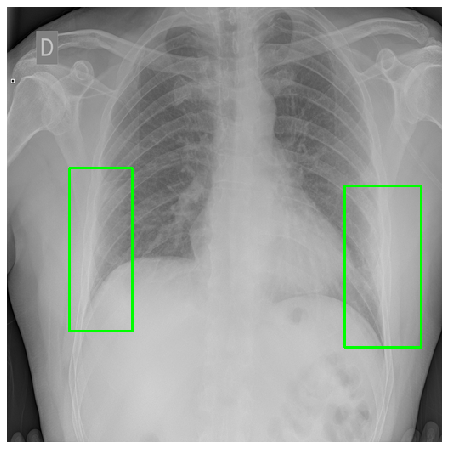

In [3]:
train_dataset = utils.get_train_dataset(0, df_folds, train)

image, target, image_id = train_dataset[15]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 255, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [4]:
target

{'boxes': tensor([[ 73.8208, 189.5748, 147.6416, 381.4697],
         [397.0505, 210.7539, 487.7446, 400.7234]], dtype=torch.float64),
 'labels': tensor([3, 3]),
 'image_id': tensor([15])}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

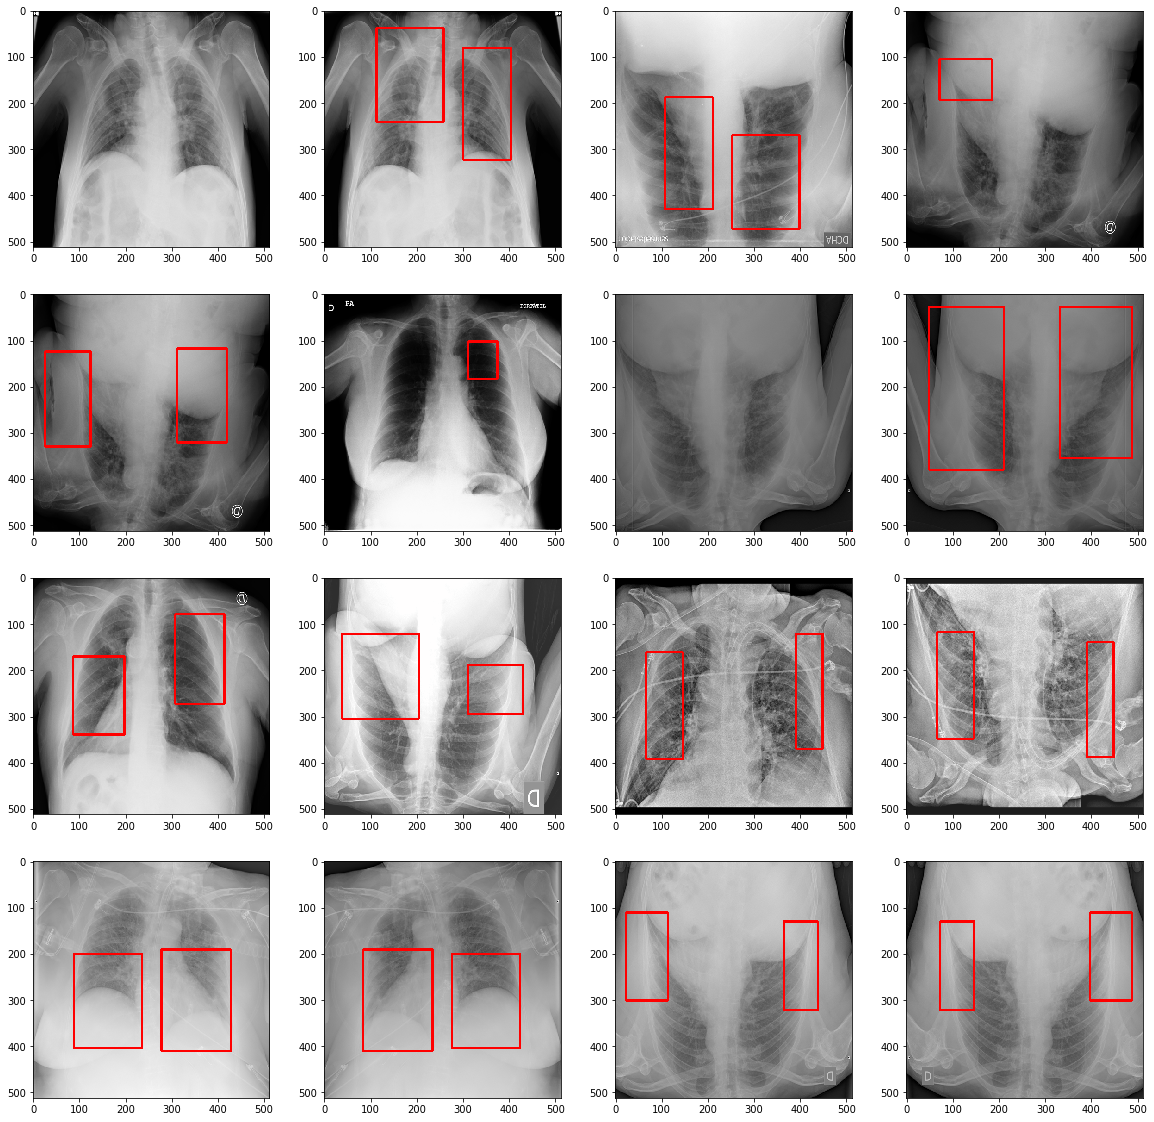

In [5]:
n_rows=4
n_cols=4

# create train dataset and data-loader
train_dataset = utils.get_train_dataset(fold_number=DefaultConfig.fold_num, 
                                        df_folds=df_folds, 
                                        train=train)
train_data_loader = utils.get_train_data_loader(train_dataset, batch_size=16)

images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# plot some augmentations!
fig, ax = plt.subplots(figsize=(20, 20),  nrows=n_rows, ncols=n_cols)
for i in range (n_rows*n_cols):    
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (255, 0, 0), 3)
    
    ax[i // n_rows][i % n_cols].imshow(sample)   